In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

root = 'dl'

Using TensorFlow backend.


# Load raw data

In [3]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
labels.head()

,CLASS
PIN,
568483,1
923748,0
2035328,0
2239386,1
2244533,1


In [4]:
data = pd.read_csv('../../tmp/raw_sequences.csv', header=0, index_col=0).loc[labels.index, 'seq']
df = pd.DataFrame(columns=['Seq', 'Class'], index=data.index)
df.loc[:, 'Seq'] = data
df.loc[:, 'Class'] = labels['CLASS']
df.head()

,Seq,Class
PIN,,
568483,10990 0 23 1 725 0 10990 0 10990 0 10990 0 109...,1
923748,66653 0 65070 0 66515 0 10962 0 105 0 56807 2 ...,0
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0
2239386,10991 0 23 3 73928 0 66560 0 66515 0 66551 0 6...,1
2244533,10990 0 23 2 23 0 10990 0 73928 0 66500 0 6656...,1


# Seq2Tokens

In [12]:
# Define tokenizer object
tokenizer = Tokenizer(char_level=False, lower=False, split=' ')

# Fit on corpus and extract tokenized sequences
tokenizer.fit_on_texts(df['Seq'])
n_feat = len(tokenizer.word_index.keys())
print(n_feat)
seq = tokenizer.texts_to_sequences(df['Seq'])

# Pad tokenized sequences
lengths = [len(x) for x in seq]
maxlen = int(np.percentile(lengths, 95))
p_seq = pad_sequences(seq, maxlen=maxlen)
print(p_seq.shape)

2774
(11744, 889)


# Training - Validation - Test split

In [13]:
# Full dataset
y = df['Class'].ravel()
X = p_seq

# Learn / Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
learn_idx, test_idx = next(sss.split(X, y))

X_learn, y_learn = X[learn_idx, :], y[learn_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

print('{} learn / {} test'.format(len(y_learn), len(y_test)))

# Training / Validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
train_idx, valid_idx = next(sss.split(X_learn, y_learn))

X_train, y_train = X_learn[train_idx, :], y_learn[train_idx]
X_valid, y_valid = X_learn[valid_idx, :], y_learn[valid_idx]

print('{} training / {} validation'.format(len(y_train), len(y_valid)))

5872 learn / 5872 test
5284 training / 588 validation


# Model \#1: Embedding + Dense (overfitting like crazy)

In [19]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 889, 64)           177536    
_________________________________________________________________
flatten_3 (Flatten)          (None, 56896)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56896)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 56897     
Total params: 234,433
Trainable params: 234,433
Non-trainable params: 0
_________________________________________________________________


In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 4s 689us/step - loss: 0.7149 - acc: 0.5195 - val_loss: 0.6746 - val_acc: 0.5578
Epoch 2/500
5284/5284 [==============================] - 3s 633us/step - loss: 0.6426 - acc: 0.6491 - val_loss: 0.6296 - val_acc: 0.6446
Epoch 3/500
5284/5284 [==============================] - 3s 633us/step - loss: 0.5718 - acc: 0.7515 - val_loss: 0.5833 - val_acc: 0.7075
Epoch 4/500
5284/5284 [==============================] - 3s 639us/step - loss: 0.5018 - acc: 0.7914 - val_loss: 0.5482 - val_acc: 0.7296
Epoch 5/500
5284/5284 [==============================] - 3s 626us/step - loss: 0.4423 - acc: 0.8234 - val_loss: 0.5706 - val_acc: 0.7092
Epoch 6/500
5284/5284 [==============================] - 3s 636us/step - loss: 0.3995 - acc: 0.8422 - val_loss: 0.5165 - val_acc: 0.7670
Epoch 7/500
5284/5284 [==============================] - 3s 618us/step - loss: 0.3565 - acc: 0.8664 - val_loss: 0.5161 - val_acc: 0

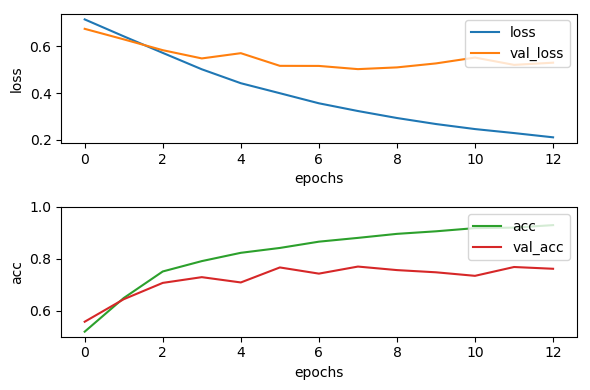

In [21]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dense.png')

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 5s 831us/step
test_loss: 0.5277 - test_acc: 0.7517


In [ ]:
# model.save_weights('embedding_dense.h5')

# Model \#2: Embedding + SimpleRNN (slow training)

In [24]:
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 889, 64)           177536    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 180,673
Trainable params: 180,673
Non-trainable params: 0
_________________________________________________________________


In [26]:
# history = model.fit(X_train, y_train,
#                     epochs=30,
#                     batch_size=128,
#                     validation_data=(X_valid, y_valid))

# Model \#3: Embedding + LSTM

In [30]:
from keras.layers import CuDNNLSTM

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 889, 64)           177536    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 190,113
Trainable params: 190,113
Non-trainable params: 0
_________________________________________________________________


In [31]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 25s 5ms/step - loss: 0.6784 - acc: 0.5833 - val_loss: 0.6328 - val_acc: 0.6497
Epoch 2/100
5284/5284 [==============================] - 25s 5ms/step - loss: 0.6025 - acc: 0.6826 - val_loss: 0.5757 - val_acc: 0.6769
Epoch 3/100
5284/5284 [==============================] - 26s 5ms/step - loss: 0.5433 - acc: 0.7322 - val_loss: 0.5189 - val_acc: 0.7500
Epoch 4/100
5284/5284 [==============================] - 25s 5ms/step - loss: 0.4925 - acc: 0.7604 - val_loss: 0.4903 - val_acc: 0.7653
Epoch 5/100
5284/5284 [==============================] - 25s 5ms/step - loss: 0.4552 - acc: 0.7875 - val_loss: 0.4914 - val_acc: 0.7568
Epoch 6/100
5284/5284 [==============================] - 25s 5ms/step - loss: 0.4575 - acc: 0.7884 - val_loss: 0.5038 - val_acc: 0.7636
Epoch 7/100
5284/5284 [==============================] - 25s 5ms/step - loss: 0.4221 - acc: 0.8073 - val_loss: 0.4624 - val_acc: 0.7721
E

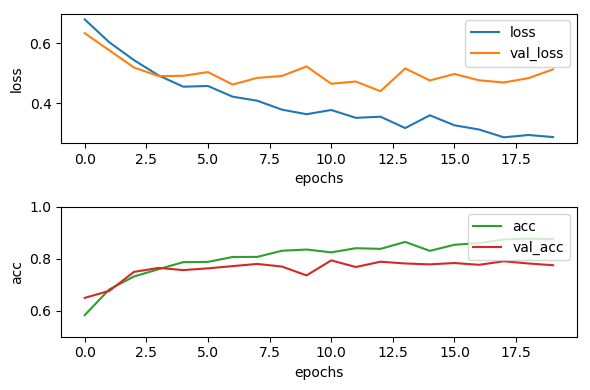

In [32]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_LSTM.png')

In [33]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 42s 7ms/step
test_loss: 0.5361 - test_acc: 0.7738


In [34]:
model.save_weights(root+'lstm.h5')

# Model \#4: Embedding + Conv1D + LSTM

In [38]:
from keras.layers import Conv1D

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 889, 64)           177536    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 885, 64)           20544     
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 210,657
Trainable params: 210,657
Non-trainable params: 0
_________________________________________________________________


In [39]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 30s 6ms/step - loss: 0.6509 - acc: 0.6238 - val_loss: 0.5845 - val_acc: 0.7143
Epoch 2/300
5284/5284 [==============================] - 28s 5ms/step - loss: 0.5710 - acc: 0.7053 - val_loss: 0.5690 - val_acc: 0.7058
Epoch 3/300
5284/5284 [==============================] - 28s 5ms/step - loss: 0.5366 - acc: 0.7377 - val_loss: 0.5222 - val_acc: 0.7585
Epoch 4/300
5284/5284 [==============================] - 28s 5ms/step - loss: 0.5178 - acc: 0.7483 - val_loss: 0.5312 - val_acc: 0.7296
Epoch 5/300
5284/5284 [==============================] - 29s 5ms/step - loss: 0.4920 - acc: 0.7653 - val_loss: 0.5132 - val_acc: 0.7415
Epoch 6/300
5284/5284 [==============================] - 29s 5ms/step - loss: 0.4756 - acc: 0.7786 - val_loss: 0.4988 - val_acc: 0.7534
Epoch 7/300
5284/5284 [==============================] - 29s 5ms/step - loss: 0.4651 - acc: 0.7799 - val_loss: 0.6862 - val_acc: 0.6259
E

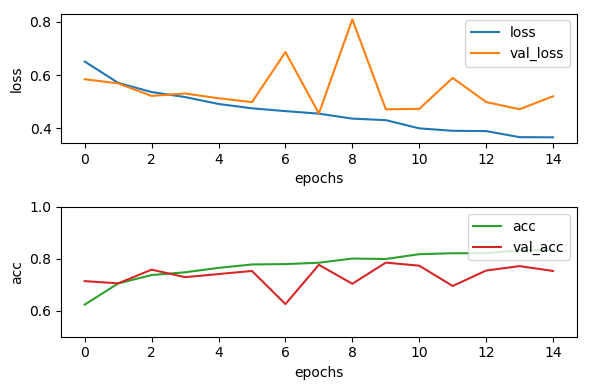

In [40]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_convLSTM.png')

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 7s 1ms/step
test_loss: 0.5042 - test_acc: 0.7757


In [42]:
model.save_weights(root+'conv_lstm.h5')

# Model \#7: Embedding + BiLSTM

In [44]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 889, 64)           177536    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                25088     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 202,689
Trainable params: 202,689
Non-trainable params: 0
_________________________________________________________________


In [45]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 10s 2ms/step - loss: 0.6706 - acc: 0.5855 - val_loss: 0.6097 - val_acc: 0.6854
Epoch 2/300
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6043 - acc: 0.6849 - val_loss: 0.5597 - val_acc: 0.7228
Epoch 3/300
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5601 - acc: 0.7250 - val_loss: 0.5405 - val_acc: 0.7177
Epoch 4/300
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5407 - acc: 0.7364 - val_loss: 0.5305 - val_acc: 0.7449
Epoch 5/300
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5136 - acc: 0.7538 - val_loss: 0.5003 - val_acc: 0.7585
Epoch 6/300
5284/5284 [==============================] - 9s 2ms/step - loss: 0.5026 - acc: 0.7585 - val_loss: 0.5053 - val_acc: 0.7619
Epoch 7/300
5284/5284 [==============================] - 9s 2ms/step - loss: 0.4882 - acc: 0.7754 - val_loss: 0.4980 - val_acc: 0.7551
Epoch 8

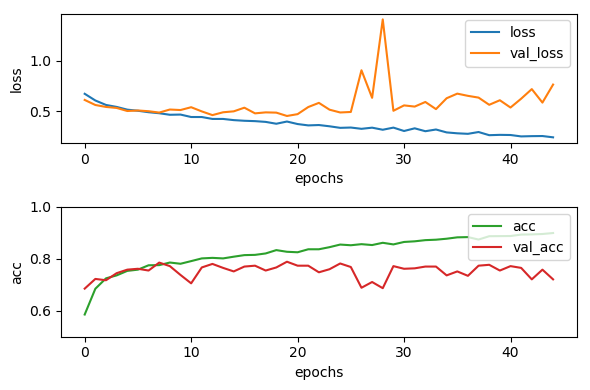

In [46]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'embedding_bilstm.png')

In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 14s 2ms/step
test_loss: 0.6941 - test_acc: 0.7490


In [48]:
# model.save_weights('embedding_bilstm.h5')

# Model \#8: Embedding + Conv1D + BiLSTM

In [51]:
from keras.optimizers import Adam
from keras.layers import MaxPooling1D

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(128, 10, activation='relu'))
model.add(MaxPooling1D(5, 1))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=1e-5, decay=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 889, 64)           177536    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 880, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 876, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41472     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 301,121
Trainable params: 301,121
Non-trainable params: 0
_________________________________________________________________


In [52]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] 

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 13s 2ms/step - loss: 0.6926 - acc: 0.5598 - val_loss: 0.6922 - val_acc: 0.5646
Epoch 2/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6919 - acc: 0.5910 - val_loss: 0.6915 - val_acc: 0.5952
Epoch 3/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6913 - acc: 0.6117 - val_loss: 0.6908 - val_acc: 0.6088
Epoch 4/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6906 - acc: 0.6158 - val_loss: 0.6901 - val_acc: 0.6378
Epoch 5/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.6899 - acc: 0.6132 - val_loss: 0.6893 - val_acc: 0.6276
Epoch 6/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6891 - acc: 0.6194 - val_loss: 0.6885 - val_acc: 0.6310
Epoch 7/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6883 - acc: 0.6241 - val_loss: 0.6875 - val_acc: 0.6293
E

5284/5284 [==============================] - 12s 2ms/step - loss: 0.5570 - acc: 0.7245 - val_loss: 0.5613 - val_acc: 0.7245
Epoch 61/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.5514 - acc: 0.7320 - val_loss: 0.5597 - val_acc: 0.7262
Epoch 62/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.5466 - acc: 0.7364 - val_loss: 0.5558 - val_acc: 0.7296
Epoch 63/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.5422 - acc: 0.7386 - val_loss: 0.5538 - val_acc: 0.7330
Epoch 64/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.5382 - acc: 0.7402 - val_loss: 0.5509 - val_acc: 0.7330
Epoch 65/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.5370 - acc: 0.7385 - val_loss: 0.5501 - val_acc: 0.7347
Epoch 66/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.5308 - acc: 0.7477 - val_loss: 0.5464 - val_acc: 0.7398
Epoch 67/500
5284/5284 [==============================

Epoch 120/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.4172 - acc: 0.8213 - val_loss: 0.4643 - val_acc: 0.7908
Epoch 121/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.4180 - acc: 0.8223 - val_loss: 0.4615 - val_acc: 0.7908
Epoch 122/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.4112 - acc: 0.8255 - val_loss: 0.4676 - val_acc: 0.7942
Epoch 123/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.4091 - acc: 0.8266 - val_loss: 0.4598 - val_acc: 0.7874
Epoch 124/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.4102 - acc: 0.8251 - val_loss: 0.4603 - val_acc: 0.7908
Epoch 125/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.4080 - acc: 0.8272 - val_loss: 0.4629 - val_acc: 0.7806
Epoch 126/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.4075 - acc: 0.8285 - val_loss: 0.4566 - val_acc: 0.7874
Epoch 127/500
5284/5284 [=========

5284/5284 [==============================] - 12s 2ms/step - loss: 0.3609 - acc: 0.8567 - val_loss: 0.4481 - val_acc: 0.8010
Epoch 180/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.3598 - acc: 0.8520 - val_loss: 0.4455 - val_acc: 0.7925
Epoch 181/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.3537 - acc: 0.8596 - val_loss: 0.4463 - val_acc: 0.8078
Epoch 182/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.3527 - acc: 0.8588 - val_loss: 0.4442 - val_acc: 0.8061
Epoch 183/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.3892 - acc: 0.8359 - val_loss: 0.4497 - val_acc: 0.7874
Epoch 184/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.3969 - acc: 0.8276 - val_loss: 0.4452 - val_acc: 0.7925
Epoch 185/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.3620 - acc: 0.8535 - val_loss: 0.4549 - val_acc: 0.8095
Epoch 186/500
5284/5284 [=======================

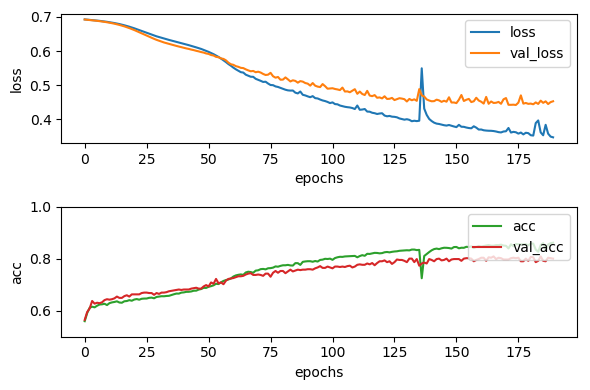

In [53]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_conv_bilstm.png')

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 14s 2ms/step
test_loss: 0.4852 - test_acc: 0.7667


# Model \#9: Embedding + Conv1D + Dense

In [55]:
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5, 1))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 889, 64)           177536    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 885, 64)           20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 881, 64)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 881, 64)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 56384)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 56385     
Total params: 254,465
Trainable params: 254,465
Non-trainable params: 0
_________________________________________________________________


In [56]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)]

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 2s 440us/step - loss: 0.7055 - acc: 0.5327 - val_loss: 0.6819 - val_acc: 0.5425
Epoch 2/100
5284/5284 [==============================] - 2s 355us/step - loss: 0.6251 - acc: 0.6408 - val_loss: 0.5770 - val_acc: 0.7211
Epoch 3/100
5284/5284 [==============================] - 2s 358us/step - loss: 0.5022 - acc: 0.7632 - val_loss: 0.5124 - val_acc: 0.7449
Epoch 4/100
5284/5284 [==============================] - 2s 350us/step - loss: 0.4432 - acc: 0.7922 - val_loss: 0.5379 - val_acc: 0.7194
Epoch 5/100
5284/5284 [==============================] - 2s 352us/step - loss: 0.4032 - acc: 0.8166 - val_loss: 0.4870 - val_acc: 0.7670
Epoch 6/100
5284/5284 [==============================] - 2s 355us/step - loss: 0.3773 - acc: 0.8336 - val_loss: 0.4871 - val_acc: 0.7602
Epoch 7/100
5284/5284 [==============================] - 2s 349us/step - loss: 0.3455 - acc: 0.8562 - val_loss: 0.4920 - val_acc: 0

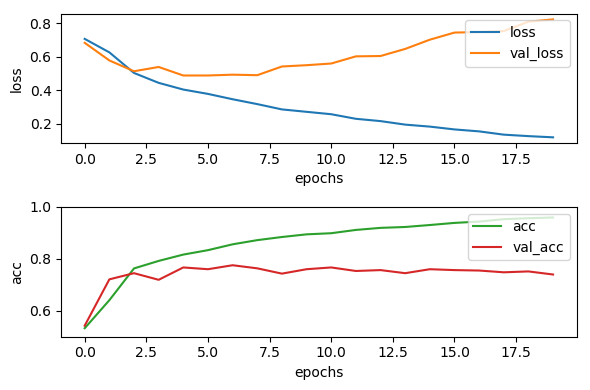

In [57]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_conv_dropout_dense.png')

In [58]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 1s 190us/step
test_loss: 0.7669 - test_acc: 0.7446


# Model \#: 10

In [59]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.25, dropout=0.25)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 889, 64)           177536    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 202,433
Trainable params: 202,433
Non-trainable params: 0
_________________________________________________________________


In [60]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] ## TODO

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 127s 24ms/step - loss: 0.6775 - acc: 0.5914 - val_loss: 0.6378 - val_acc: 0.6939
Epoch 2/100
5284/5284 [==============================] - 127s 24ms/step - loss: 0.6266 - acc: 0.6781 - val_loss: 0.5918 - val_acc: 0.6956
Epoch 3/100
5284/5284 [==============================] - 125s 24ms/step - loss: 0.5936 - acc: 0.6953 - val_loss: 0.5708 - val_acc: 0.7245
Epoch 4/100
5284/5284 [==============================] - 123s 23ms/step - loss: 0.5688 - acc: 0.7176 - val_loss: 0.5682 - val_acc: 0.7092
Epoch 5/100
5284/5284 [==============================] - 127s 24ms/step - loss: 0.5530 - acc: 0.7292 - val_loss: 0.5277 - val_acc: 0.7517
Epoch 6/100
5284/5284 [==============================] - 126s 24ms/step - loss: 0.5371 - acc: 0.7381 - val_loss: 0.5304 - val_acc: 0.7381
Epoch 7/100
5284/5284 [==============================] - 125s 24ms/step - loss: 0.5290 - acc: 0.7468 - val_loss: 0.5279 - val

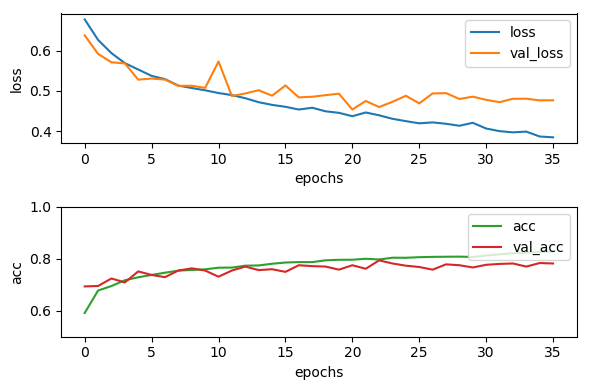

In [61]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dropout_LSTM.png')

In [62]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 117s 20ms/step
test_loss: 0.4917 - test_acc: 0.7738
